<h1 color="red"> PROJET ML: mort survenu apres un arret cardiaque</h1>

<h3> Etudiants:
<ul>
    <li>SEREME Ousmane</li>
    <li>ZONGO Celse Darius P</li>
    <li>ZONGO Rasmane</li>
</ul>
</h3>
 
 

## IMPORT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator ,MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss



sc = SparkContext.getOrCreate()
#Create object of spark session

spark = SparkSession.builder.appName('ml-projet-pipeline').getOrCreate()

### import dataset

In [2]:
#Read the csv file
df=spark.read.csv('data/heart_failure_clinical_records_dataset.csv',inferSchema=True,header=True)
df.toPandas().head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


# DATASET EXPLORATION

Text(0.5, 1.0, 'Correlation Matrix')

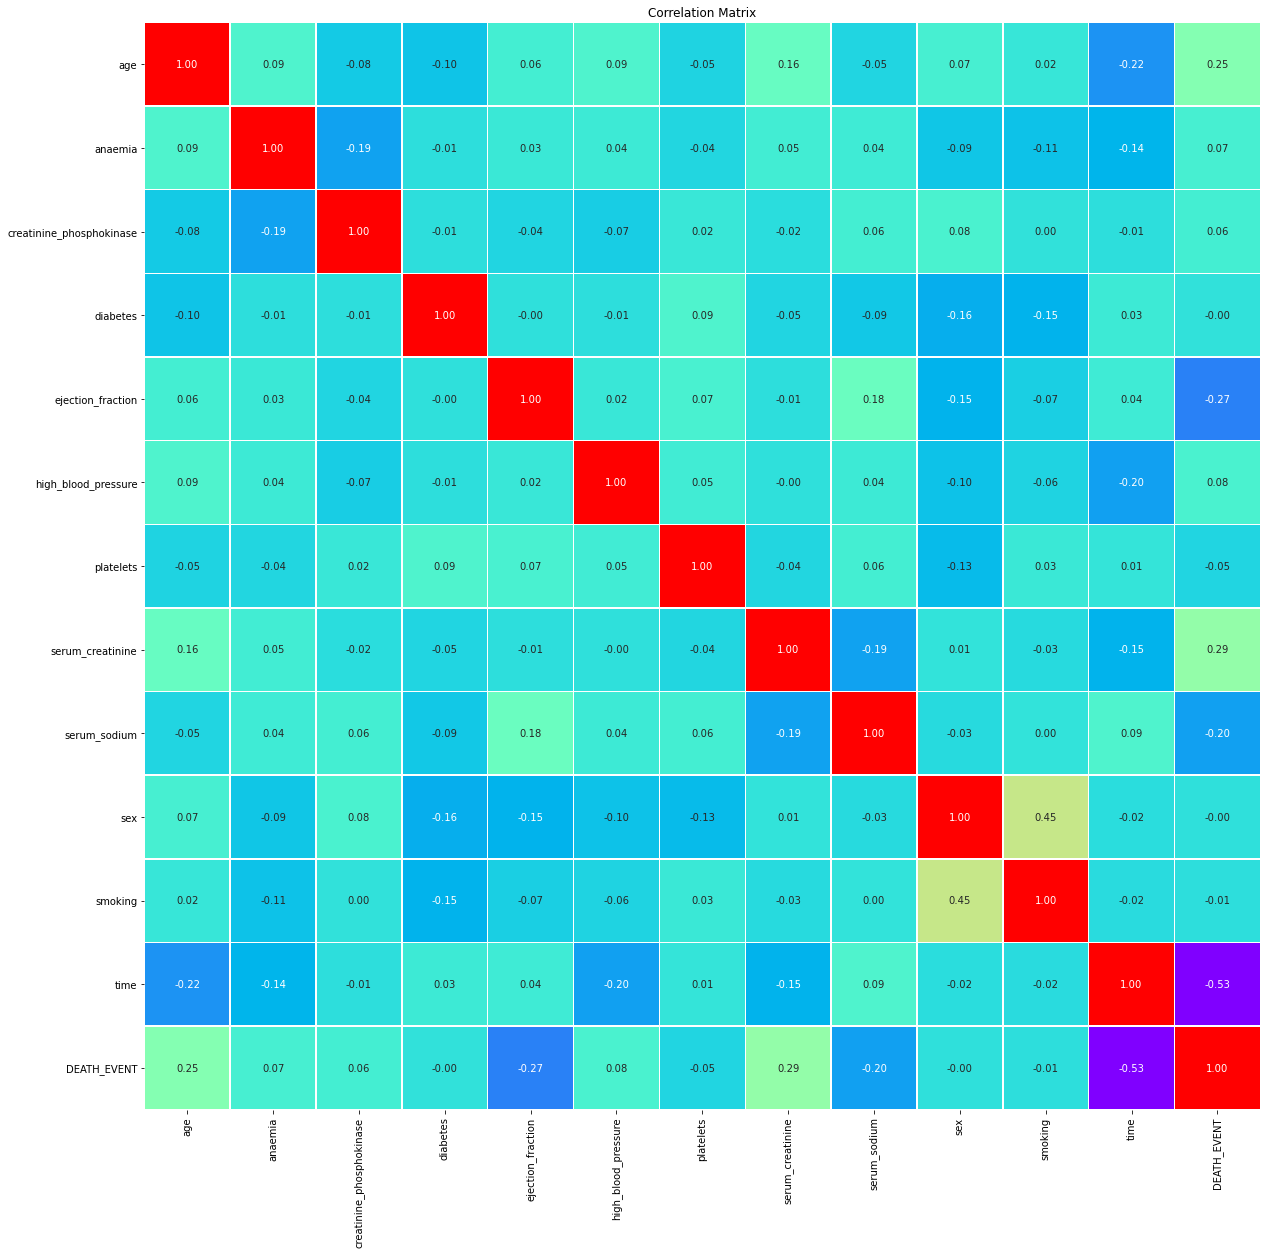

In [3]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.toPandas().corr(), annot=True, cmap='rainbow',
            cbar=False, linewidth=0.5, fmt='.2f')
plt.title('Correlation Matrix')

In [4]:
print(df.toPandas().corr()["DEATH_EVENT"].abs().sort_values(ascending=False))

DEATH_EVENT                 1.000000
time                        0.526964
serum_creatinine            0.294278
ejection_fraction           0.268603
age                         0.253729
serum_sodium                0.195204
high_blood_pressure         0.079351
anaemia                     0.066270
creatinine_phosphokinase    0.062728
platelets                   0.049139
smoking                     0.012623
sex                         0.004316
diabetes                    0.001943
Name: DEATH_EVENT, dtype: float64


<AxesSubplot:xlabel='sex', ylabel='count'>

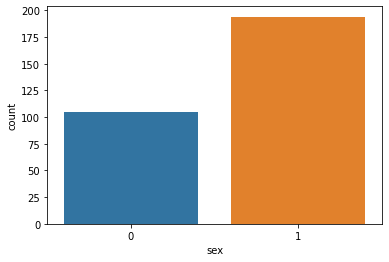

In [5]:
sns.countplot(x='sex', data=df.toPandas())

la majorite des sujets est masculin

<AxesSubplot:xlabel='age', ylabel='count'>

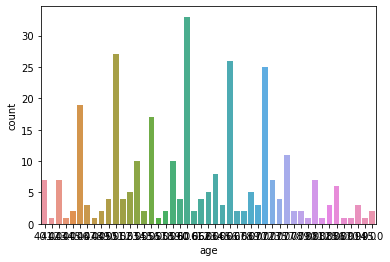

In [6]:
sns.countplot(x='age', data=df.toPandas())

# Preparation des donnees

In [7]:
for c in df.columns:
    count=df.filter(c+" is   NULL" or c+"is ''" or c+"is  NaN" or c+"is  null").count()
    print(c+" column has "+ str(count) +" missing values\n")

age column has 0 missing values

anaemia column has 0 missing values

creatinine_phosphokinase column has 0 missing values

diabetes column has 0 missing values

ejection_fraction column has 0 missing values

high_blood_pressure column has 0 missing values

platelets column has 0 missing values

serum_creatinine column has 0 missing values

serum_sodium column has 0 missing values

sex column has 0 missing values

smoking column has 0 missing values

time column has 0 missing values

DEATH_EVENT column has 0 missing values



aucune valeur manquante, donc pas besoin d'imputer des donnees

In [8]:
#colonne a vectoriser
col = [col for col in df.columns if col!= 'DEATH_EVENT'  ]
col

['age',
 'anaemia',
 'creatinine_phosphokinase',
 'diabetes',
 'ejection_fraction',
 'high_blood_pressure',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'sex',
 'smoking',
 'time']

In [9]:
df= df.withColumnRenamed("DEATH_EVENT","label")

In [10]:
## pipeline, on vectorise les donnees et on les echelonne


va =  VectorAssembler().setInputCols(col).setOutputCol("features_to_be_scale")

df_feature = va.transform(df)

scaler =  StandardScaler().setInputCol("features_to_be_scale").setOutputCol("features")
scaled_df = scaler.fit(df_feature).transform(df_feature).select("features", "label")

scaled_df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[6.30527144514296...|    1|
|[4.62386572643817...|    1|
|[5.46456858579056...|    1|
|[4.20351429676197...|    1|
|[5.46456858579056...|    1|
+--------------------+-----+
only showing top 5 rows



### division des donnees en test et donne d'entrainement

In [11]:
trainSet, testSet = scaled_df.randomSplit([0.7,0.3])

# REGRESSION LOGISTIQUE

In [12]:

lr= LogisticRegression(labelCol="label")

lr_model= lr.fit(trainSet)
lr_result = lr_model.transform(testSet)
log_summary=lr_model.summary
log_summary.predictions.show()

lr_result.select( 'label', 'prediction', 'probability').show(5)






+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[3.36281143740957...|  0.0|[4.65679695602764...|[0.99059250885823...|       0.0|
|[3.36281143740957...|  0.0|[2.57252399930145...|[0.92907220024836...|       0.0|
|[3.36281143740957...|  0.0|[4.47521422282942...|[0.98874043908866...|       0.0|
|[3.36281143740957...|  0.0|[5.09989911462878...|[0.99393959083744...|       0.0|
|[3.36281143740957...|  0.0|[4.50850679062633...|[0.98910511062019...|       0.0|
|[3.44688172334481...|  0.0|[2.60753581875824...|[0.93134500023136...|       0.0|
|[3.53095200928005...|  0.0|[2.81173984284655...|[0.94330693597414...|       0.0|
|[3.53095200928005...|  0.0|[5.76231536273965...|[0.99686602858283...|       0.0|
|[3.53095200928005...|  0.0|[1.50845000633151...|[0.81883138425834...|       0.0|
|[3.530952009280

## evaluation

In [13]:
lr_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
lr_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
lr_AUC  = lr_eval.evaluate(lr_result)
lr_ACC  = lr_eval2.evaluate(lr_result, {lr_eval2.metricName:"accuracy"})





PredAndLabels           = lr_result.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)




#confusion Matrix
cm_lr_result = lr_result.crosstab("prediction", "label")
cm_lr_result = cm_lr_result.toPandas()
cm_lr_result

#calculate Accuracy, Sensitivity, Specificity, Precision
TP = cm_lr_result["1"][0]
FP = cm_lr_result["0"][0]
TN = cm_lr_result["0"][1]
FN = cm_lr_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print("performance de la regression logistique")
print ("Accuracy = %0.2f" %Accuracy )
print ("Sensibilite = %0.2f" %Sensitivity )
print ("Specificite = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )
print("AUC=%.2f" % AUC)



performance de la regression logistique
Accuracy = 0.75
Sensibilite = 0.55
Specificite = 0.87
Precision = 0.71
AUC=0.85


# Arbre de Choix

In [14]:
from pyspark.ml.classification import DecisionTreeClassifier


dt = DecisionTreeClassifier( labelCol = 'label')

dt_model = dt.fit(trainSet)
dt_result = dt_model.transform(testSet)
dt_result.show(10)




+--------------------+-----+-------------+-------------+----------+
|            features|label|rawPrediction|  probability|prediction|
+--------------------+-----+-------------+-------------+----------+
|[3.36281143740957...|    0|  [117.0,3.0]|[0.975,0.025]|       0.0|
|[3.36281143740957...|    0|  [117.0,3.0]|[0.975,0.025]|       0.0|
|[3.53095200928005...|    1|   [0.0,26.0]|    [0.0,1.0]|       1.0|
|[3.69909258115053...|    0|  [117.0,3.0]|[0.975,0.025]|       0.0|
|[3.78316286708577...|    0|  [117.0,3.0]|[0.975,0.025]|       0.0|
|[3.78316286708577...|    1|    [4.0,0.0]|    [1.0,0.0]|       0.0|
|[3.78316286708577...|    0|  [117.0,3.0]|[0.975,0.025]|       0.0|
|[3.78316286708577...|    1|  [117.0,3.0]|[0.975,0.025]|       0.0|
|[3.78316286708577...|    1|    [0.0,2.0]|    [0.0,1.0]|       1.0|
|[4.11944401082673...|    1|   [0.0,26.0]|    [0.0,1.0]|       1.0|
+--------------------+-----+-------------+-------------+----------+
only showing top 10 rows



### evaluation

In [16]:
print("Performance Arbre de choix")

dt_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
dt_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
dt_AUC  = dt_eval.evaluate(dt_result)
dt_ACC  = dt_eval2.evaluate(dt_result, {dt_eval2.metricName:"accuracy"})

#ROC Grafik
PredAndLabels           = dt_result.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)







#confusion matrix
cm_dt_result = dt_result.crosstab("prediction", "label")
cm_dt_result = cm_dt_result.toPandas()
cm_dt_result

#calculate accuracy, sensitivity, specificity and precision
TP = cm_dt_result["1"][0]
FP = cm_dt_result["0"][0]
TN = cm_dt_result["0"][1]
FN = cm_dt_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

# Area under ROC

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensibilite = %0.2f" %Sensitivity )
print ("Specificite = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )
print("AUC=%.2f" % AUC)


Performance Arbre de choix
Accuracy = 0.80
Sensibilite = 0.71
Specificite = 0.85
Precision = 0.73
AUC=0.85


# FORET Aleatoire

In [17]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rf_model = rf.fit(trainSet)
rf_result = rf_model.transform(testSet)
rf_result.show(10)


+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[3.36281143740957...|    0|[19.3140118538113...|[0.96570059269056...|       0.0|
|[3.36281143740957...|    0|[19.3787357998161...|[0.96893678999080...|       0.0|
|[3.53095200928005...|    1|[4.16910680037262...|[0.20845534001863...|       1.0|
|[3.69909258115053...|    0|[17.4116209715669...|[0.87058104857834...|       0.0|
|[3.78316286708577...|    0|[19.3430409258258...|[0.96715204629129...|       0.0|
|[3.78316286708577...|    1|[8.68191846326558...|[0.43409592316327...|       1.0|
|[3.78316286708577...|    0|[16.8290912216426...|[0.84145456108213...|       0.0|
|[3.78316286708577...|    1|[19.1036573438072...|[0.95518286719036...|       0.0|
|[3.78316286708577...|    1|[11.9255656748314...|[0.59627828374157...|       0.0|
|[4.119444010826

### evaluation

In [18]:

rf_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
rf_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
rf_AUC  = rf_eval.evaluate(rf_result)
rf_ACC  = rf_eval2.evaluate(rf_result, {rf_eval2.metricName:"accuracy"})

print("Performance Foret aleatoire")


#ROC Grafik
PredAndLabels           = rf_result.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)



#Confusion Matrix
cm_rf_result = rf_result.crosstab("prediction", "label")
cm_rf_result = cm_rf_result.toPandas()
cm_rf_result

#calculate accurary,sensitivity, specificity and precision 
TP = cm_rf_result["1"][0]
FP = cm_rf_result["0"][0]
TN = cm_rf_result["0"][1]
FN = cm_rf_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensibilite = %0.2f" %Sensitivity )
print ("Specificite = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )
print("AUC=%.2f" % AUC)


Performance Foret aleatoire
Accuracy = 0.83
Sensibilite = 0.68
Specificite = 0.92
Precision = 0.84
AUC=0.85


# Arbre Degrade

In [19]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
gbt_model = gbt.fit(trainSet)
gbt_result = gbt_model.transform(testSet)
gbt_result.show(10)




+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[3.36281143740957...|    0|[1.18739932900492...|[0.91488527776030...|       0.0|
|[3.36281143740957...|    0|[1.28967040935923...|[0.92952009672739...|       0.0|
|[3.53095200928005...|    1|[-1.3208230559613...|[0.06650576746613...|       1.0|
|[3.69909258115053...|    0|[0.25241884644702...|[0.62359553166594...|       0.0|
|[3.78316286708577...|    0|[1.31831329479011...|[0.93318192788276...|       0.0|
|[3.78316286708577...|    1|[0.11096350679783...|[0.55525515560635...|       0.0|
|[3.78316286708577...|    0|[1.32541888295798...|[0.93406260698796...|       0.0|
|[3.78316286708577...|    1|[1.11584430521440...|[0.90305928603962...|       0.0|
|[3.78316286708577...|    1|[-0.7665595000061...|[0.17753779709928...|       1.0|
|[4.119444010826

### evaluation

In [128]:
gbt_eval = BinaryClassificationEvaluator(rawPredictionCol="probability",labelCol="label")
gbt_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
gbt_AUC  = gbt_eval.evaluate(gbt_result)
gbt_ACC  = gbt_eval2.evaluate(gbt_result, {gbt_eval2.metricName:"accuracy"})

print("Performance Arbre degrade")


#ROC Grafik
PredAndLabels           = gbt_result.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)


#Confusion Matrix
cm_gbt_result = gbt_result.crosstab("prediction", "label")
cm_gbt_result = cm_gbt_result.toPandas()
cm_gbt_result

#calculate accuracy, sensitivity, specificity and precision
TP = cm_gbt_result["1"][0]
FP = cm_gbt_result["0"][0]
TN = cm_gbt_result["0"][1]
FN = cm_gbt_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensibilite = %0.2f" %Sensitivity )
print ("Specificite = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

print("AUC=%.2f" % AUC)


Performance Arbre degrade
Accuracy = 0.80
Sensibilite = 0.58
Specificite = 0.87
Precision = 0.55
AUC=0.81


# Hyper-tuning

In [20]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 

rf_hyper= RandomForestClassifier(featuresCol='features', labelCol="label")

# Hyper-Parameter Tuning
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5,10]) \
    .addGrid(rf_hyper.numTrees, [40, 60, 80, 100]) \
    .build()
crossval_rf = CrossValidator(estimator=rf_hyper,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=3) 
#fit model to data train
rf_model_hyper=crossval_rf.fit(trainSet)

#transfrom model to data test
rf_result_hyper = rf_model_hyper.transform(testSet)

#view id, label, prediction and probability from result of modelling
rf_result_hyper.show(5)

#Random Forest With Hyper-Parameter Evaluation
#Evaluate model by calculating accuracy and area under curve (AUC)
rf_hyper_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
rf_hyper_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
rf_hyper_AUC  = rf_hyper_eval.evaluate(rf_result_hyper)
rf_hyper_ACC  = rf_hyper_eval2.evaluate(rf_result_hyper, {rf_hyper_eval2.metricName:"accuracy"})

print(" Performance apres tuning")


#ROC Grafik
PredAndLabels           = rf_result_hyper.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)






#Confusion Matrix
cm_rf_result_hyper = rf_result_hyper.crosstab("prediction", "label")
cm_rf_result_hyper = cm_rf_result_hyper.toPandas()
cm_rf_result_hyper

#calculate accuracy, sensitivity, specificity and precision
TP = cm_rf_result_hyper["1"][0]
FP = cm_rf_result_hyper["0"][0]
TN = cm_rf_result_hyper["0"][1]
FN = cm_rf_result_hyper["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensibilite = %0.2f" %Sensitivity )
print ("Specificite = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

print("AUC=%.4f" % AUC)


+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[3.36281143740957...|    0|[56.9237665643739...|[0.94872944273956...|       0.0|
|[3.36281143740957...|    0|[56.9980560936029...|[0.94996760156004...|       0.0|
|[3.53095200928005...|    1|[18.0044821458895...|[0.30007470243149...|       1.0|
|[3.69909258115053...|    0|[47.8011800639543...|[0.79668633439923...|       0.0|
|[3.78316286708577...|    0|[55.1139876800055...|[0.91856646133342...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows

 Performance apres tuning
Accuracy = 0.83
Sensibilite = 0.68
Specificite = 0.92
Precision = 0.84
AUC=0.8524
